# Equity Analyst Agent with Assistants API and Function calling

### This notebook showcases the capabilities of Azure OpenAI's Assistants API for an Equity Analyst Agent. 

Install the necessary Python packages (openai, matplotlib, tenacity, python-dotenv) for the notebook to function.

In [ ]:
%pip install openai matplotlib tenacity python-dotenv

Imports the necessary Python modules and classes used in the notebook. Note the openai module is used to interact with the Assistants API.

In [1]:
import io
import os
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Iterable
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile

### Environment Configuration
This cell is crucial for setting up the environment configuration necessary for the notebook to interact with Azure OpenAI. 

- **Requirement**: Ensure that a `.env` file exists in the same directory as this notebook. This file should contain the necessary API credentials and configuration details, which you can obtain from https://ai.azure.com 
- **Keys in .env File**: The `.env` file must include the following keys:
  - `OPENAI_ENDPOINT`: The endpoint URL for the Azure OpenAI service.
  - `OPENAI_API_KEY`: Your API key for accessing Azure OpenAI services.
  - `OPENAI_MODEL_NAME`: The name of the specific Azure OpenAI model you intend to use.


In [2]:
load_dotenv(".env")
api_endpoint = os.getenv("OPENAI_ENDPOINT")
api_key = os.getenv("OPENAI_API_KEY")
api_deployment_name = os.getenv("OPENAI_MODEL_NAME")
api_version = "2024-02-15-preview"

### Initializing Azure OpenAI Client

Initializes `AzureOpenAI` client with necessary credentials and configurations:
- `api_key`: API key for authentication.
- `api_version`: Targeted API version, set to `"2024-02-15-preview"`.
- `azure_endpoint`: Endpoint URL for Azure OpenAI services.

This step is crucial for establishing communication with Azure OpenAI services.


In [3]:
client = AzureOpenAI(api_key=api_key, 
                     api_version=api_version, 
                     azure_endpoint=api_endpoint)

### Create the assistant with tools and files

![How Assistants work](./images/assistants.png)


The `create_assistant` function creates an assistant with tools and files. The function takes the following parameters:
- `name`: The name of the assistant.
- `instructions`: The system message (or meta prompt) that gives the assistant a persona and context.
- `tools`: A list of tools that the assistant can use to perform tasks. Currently, these are `code_intrepreter` and `retriever`.
- `functions`: Custom functions that the assistant can use to perform tasks. Similar to function calling feature.
- `model`: The name of the model to use for the assistant.

In [4]:
# Fetch the files under the datasets directory
DATASETS = "datasets/"

def upload_file(client: AzureOpenAI, path: Path) -> FileObject:
    with path.open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

assistant_files = [upload_file(client, Path(DATASETS) / file) for file in os.listdir(DATASETS)]
file_ids = [file.id for file in assistant_files]

Create the assistant with tools and files

In [5]:
assistant = client.beta.assistants.create(
    name="Equity Analyst",
    instructions=("You are an equity analyst that performs analysis on the given datasets. "
                  "Use the provided file only."),
    tools=[{"type": "code_interpreter"}],
    file_ids=file_ids,
    model=api_deployment_name
)

Create a thread, which represents a conversation. It is recommended to create one thread per user. 

In [6]:
thread = client.beta.threads.create()

Helper function to format the response from the assistant.

In [7]:
def format_response(messages: Iterable[MessageFile]) -> None:

    message_list = []

    # Iterate through the messages and break when a user message is encountered
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the list of messages
    message_list = message_list[::-1]

    for message in message_list:
        for item in message.content:
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                try:
                    response_content = client.files.content(item.image_file.file_id)
                    data_in_bytes = response_content.read()
                    readable_buffer = io.BytesIO(data_in_bytes)
                    image = plt.imread(readable_buffer, format='jpeg')
                    plt.imshow(image)
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Exception: {e}")

Create a thread run

![Run lifecycle](https://cdn.openai.com/API/docs/images/diagram-1.png)

In [8]:
from tenacity import retry, stop_after_attempt, wait_exponential, RetryError, retry_if_exception_type

# Custom exception for specific retry condition
class NotCompletedException(Exception):
    pass

@retry(stop=stop_after_attempt(15), 
       wait=wait_exponential(multiplier=1.5, min=4, max=20),
       retry=retry_if_exception_type(NotCompletedException))
def get_run_lifecycle_status(thread_id, run_id):
    run = client.beta.threads.runs.retrieve(thread_id=thread_id, run_id=run_id)
    print(f"Run status: {run.status}")
    if run.status in ["completed", "failed", "expired", "cancelled"]:
        return run
    elif run.status == "requires_action":
        # Handle cases that require action differently
        # For example, you might not want to retry in this case
        pass
    else:
        # This will cause a retry for statuses not explicitly handled above
        raise NotCompletedException("Run not completed yet")

def analyst_assistant(content: str):
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions=f"You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools.",
    )

    try:
        run = get_run_lifecycle_status(thread.id, run.id)
        messages = client.beta.threads.messages.list(thread_id=thread.id)
        format_response(messages)
    except RetryError:
        print("Operation failed or timed out after maximum retries.")
    except NotCompletedException:
        print("Operation did not complete in the expected status.")


### Have the assistant perform a DCF valuation

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
user:
Visualize the data and provide insights on the trends.

assistant:
First, let's load the data from the uploaded file and take a quick look at its structure and contents to understand what kind of data we're working with. Based on this, we can decide how best to visualize it and analyze the trends. 

I'll start by loading the data using Python and displaying the first few rows.

assistant:
The dataset appears to contain financial projections for a company, including the following columns:

- `Year`: The fiscal year for the projection.
- `Projected Revenue`: Expected revenue for the year.
- `Projected EBIT` (Earnings Before Interest and Taxes): Expected operating income for the year.
- `Projected Net Income`: Expected net income for the year.
- `Projected Free Cash Flow`: Expected free cash flow for 

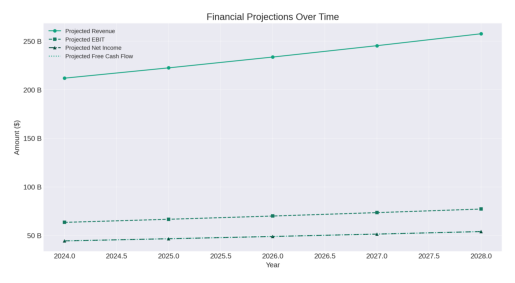

assistant:
The plot above visualizes the projected financial metrics from the dataset. Here are the key trends and insights we can observe:

- All metrics (Projected Revenue, Projected EBIT, Projected Net Income, and Projected Free Cash Flow) are on an upward trend, implying the company is expecting growth in its financial performance over the years.
- The Projected Revenue appears to be the highest among the metrics, with a steady climb each year, which indicates increasing sales or expansion of the company's business operations.
- Projected EBIT and Projected Net Income, while lower than Projected Revenue, also show a consistent increase, suggesting improving profitability.
- Projected Free Cash Flow follows a similar upward pattern, indicating the company’s ability to generate cash after accounting for capital expenditures is also expected to grow.

Next, let’s visualize the Present Value of Free Cash Flow compared to the Projected Free Cash Flow to see the effect of discounting cas

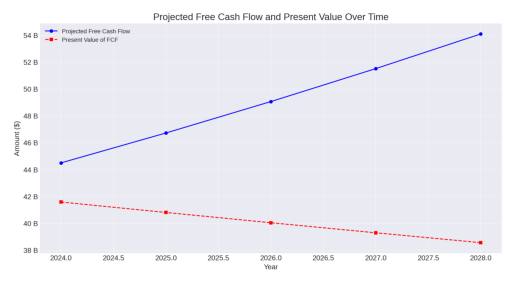

assistant:
The chart above compares the Projected Free Cash Flow (FCF) and the Present Value of FCF over time. The following insights can be gleaned from this comparison:

- As we would expect, the Present Value of FCF is lower than the nominal Projected FCF for each year, reflecting the application of the discount factor, which accounts for the time value of money. This is a common financial analysis practice to calculate the current value of future cash flows.
- The gap between the Projected FCF and its Present Value seems to be fairly consistent, suggesting a stable discount rate is used across the projection period. However, it naturally increases with time as the cash flows are discounted back to their present values from increasingly distant future years.
- The declining Present Value of FCF, despite the increase in nominal terms, suggests that the impact of discounting becomes more significant with a further out future cash flow due to higher cumulative discounting.

Overall, th

In [9]:
analyst_assistant("Visualize the data and provide insights on the trends.")

In [10]:
analyst_assistant("Use python code to perform a discounted cash flow valuation using the given dataset. Make generic assumptions")

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
user:
Use python code to perform a discounted cash flow valuation using the given dataset. Make generic assumptions

assistant:
To perform a discounted cash flow (DCF) valuation, we calculate the present value (PV) of projected free cash flows (FCF) for each year and then take the sum of these values. This is the value of the cash flows the company is expected to generate in the future, brought back to today's dollars.

The formula for the present value of an individual year's FCF is:
\[ PV = \frac{FCF}{(1 + r)^n} \]
where:
- \( FCF \) is the projected free cash flow for the year,
- \( r \) is the discount rate,
- \( n \) is the number of years from now.

Since the dataset already includes a "Discount Factor", we don't need to explicitly apply the discount rate \( r \). We can simply multiply the "Projected Free Cash Flow" by the "Discount Factor" to 

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
user:
Visualize this information. Seems incorrect

assistant:
Apologies for any confusion in the previous chart. I will rectify the visualization by distinctly presenting the present value of the free cash flows year by year and emhpasize the present value of terminal value, so the distinction and proportions are clear. Let's create a more accurate chart.



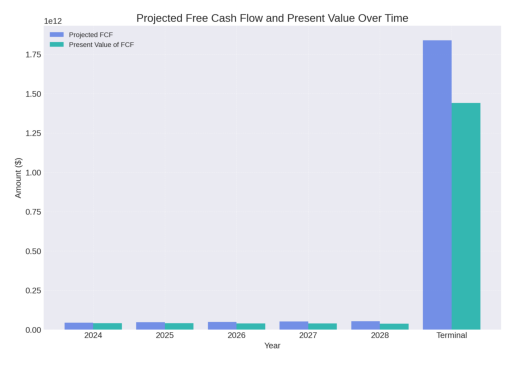

assistant:
The revised bar chart shows:

- The blue bars represent the projected free cash flow (FCF) for each year specified in the dataset, without discounting.
- The green bars represent the present value of those cash flows after discounting.
- The terminal value is also plotted as a projected FCF (blue) and its discounted present value (green) in the final bars.

This visualization more accurately depicts how the present value of each year's free cash flow compares to the non-discounted projected amounts and the overall significance of the terminal value in the DCF valuation calculation.

I hope this chart meets your expectations. If there is anything else I can assist you with, please let me know.



In [12]:
analyst_assistant("Visualize this information")

### Delete the thread and assistant

In [ ]:
for entity in [(client.beta.assistants, assistant), (client.beta.threads, thread)]:
    entity[0].delete(entity[1].id)

for file in assistant_files:
    client.files.delete(file.id)